In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Mounted at /content/drive


In [29]:
import os
import re
# from pandarallel import pandarallel
import keras
# from pivottablejs import pivot_ui
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow
from imblearn.over_sampling import SMOTE
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Embedding, Flatten, Input,
                          MaxPooling2D)
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report

In [3]:
emotion_label = {
    0: 'Angry',
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [4]:
loc = '/content/drive/MyDrive/Study/DS/Computer Vision/Face Emotion Detection/'
# loc = '' 
df = pd.read_csv(f'{loc}data/train.csv')
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
df = df.sample(frac = 1, random_state = 0)

Sample Image

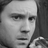

In [6]:
array = np.array(str(df.loc[0, 'pixels']).split(' '), dtype=np.uint8)
array = np.reshape(array, (48, 48))

new_image = Image.fromarray(array)
new_image

### Data Preprocessing

In [7]:
df.isnull().sum()[df.isnull().sum()>0]
# No null values.

Series([], dtype: int64)

In [8]:
df['emotion'] = df['emotion'].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 18082 to 2732
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   emotion  28709 non-null  category
 1   pixels   28709 non-null  object  
dtypes: category(1), object(1)
memory usage: 1.5+ MB


### Univariate Analysis

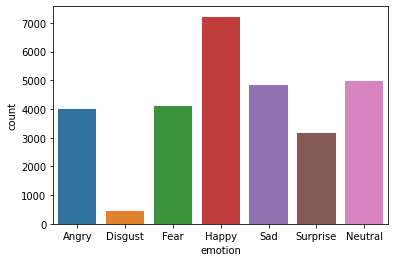

In [10]:
sns.countplot(x = 'emotion', data = df, order = list(emotion_label.keys()))
plt.xticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()))
plt.show()

Inference:

1. Disgust values are very less. We could try turning Images at  certain angle to create more data.
2. 

### Feature Engineering

#### Splitting the data in Train and Validation

In [11]:
# def correct_pixel_column(x):
#     x = [int(i) for i in str(x).split(' ')]
#     x = np.asarray(x)
#     x = x / 255
#     x = x.reshape(48, 48)
#     return np.expand_dims(x, -1)
#     # return x.reshape(48, 48)

# # pandarallel.initialize(progress_bar = True)
# df['pixels'] = df['pixels'].apply(correct_pixel_column)
# # df['pixels'] = df['pixels'].parallel_apply(correct_pixel_column)
# df.head()

In [12]:
data = df['pixels'].to_list()
x = []

for j in data:
  xx = [int(i) for i in str(j).split(' ')]
  xx = np.asarray(xx)
  xx = xx / 255
  xx = xx.reshape(48, 48)
  x.append(xx.astype('float32'))

x = np.asarray(x)
x = np.expand_dims(x, -1)

y = df['emotion']

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.35, random_state=123)
x_train.shape

(18660, 48, 48, 1)

In [14]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3995,  436, 4097, 7215, 4830, 3171, 4965]))

In [15]:
class_weights = class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(y),
        y = y)

In [16]:
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.8260394187886635}

### Creating a simple CNN for now.

In [20]:
def cnn_model(input_shape=(48,48,1)):
    num_classes = 7

    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'i', input_shape = input_shape))    
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'c1_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'c1_2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p1_1'))

    model.add(Dropout(0.3, name = 'd1_1')) #the 2-nd block
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'c2_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'c2_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'c2_3'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p2_1'))

    model.add(Dropout(0.3, name = 'd2_1')) #the 3-rd block
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_3'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p3_1'))

    model.add(Dropout(0.3, name = 'd3_1'))#the 4-th block
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_3'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p4_1'))
    model.add(Dropout(0.3, name = 'd4_1'))
    
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_3'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p5_1'))
    model.add(Dropout(0.3, name = 'd5_1')) #Flatten and output

    model.add(Flatten(name = 'f'))

    model.add(Dense(500, activation='relu', name = 'h'))
    model.add(Dense(num_classes, activation='softmax', name = 'o'))
    
    return model

In [21]:
model = cnn_model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i (Conv2D)                  (None, 48, 48, 64)        640       
                                                                 
 c1_1 (Conv2D)               (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 c1_2 (Conv2D)               (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 p1_1 (MaxPooling2D)         (None, 24, 24, 64)       

#### Implementing Data Augmentation

In [26]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
    )

model.fit( 
    datagen.flow(x, y, batch_size=64, subset='training'),
    validation_data = datagen.flow(x, y, batch_size=64, subset='validation'),
    epochs = 100,
    class_weight = class_weights,
    use_multiprocessing = True
    )

Epoch 1/100
359/359 [==============================] - 34s 94ms/step - loss: 0.8913 - accuracy: 0.6458 - val_loss: 1.0584 - val_accuracy: 0.6044
Epoch 2/100
359/359 [==============================] - 32s 89ms/step - loss: 0.8988 - accuracy: 0.6367 - val_loss: 1.0324 - val_accuracy: 0.6140
Epoch 3/100
359/359 [==============================] - 32s 89ms/step - loss: 0.8993 - accuracy: 0.6388 - val_loss: 1.0779 - val_accuracy: 0.6072
Epoch 4/100
359/359 [==============================] - 32s 88ms/step - loss: 0.8856 - accuracy: 0.6472 - val_loss: 1.0948 - val_accuracy: 0.5994
Epoch 5/100
359/359 [==============================] - 32s 88ms/step - loss: 0.8893 - accuracy: 0.6429 - val_loss: 1.0333 - val_accuracy: 0.6218
Epoch 6/100
359/359 [==============================] - 32s 90ms/step - loss: 0.8726 - accuracy: 0.6476 - val_loss: 1.0235 - val_accuracy: 0.6267
Epoch 7/100
359/359 [==============================] - 32s 89ms/step - loss: 0.8768 - accuracy: 0.6514 - val_loss: 1.0585 - val_ac

In [27]:
y_pred = []
y_pred_score = model.predict(x_val)
for i in y_pred_score:
  y_pred.append(i.argmax())

315/315 [==============================] - 4s 13ms/step


In [34]:
print(classification_report(y_val, y_pred, labels = list(set(y_pred))))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1377
           1       0.91      0.94      0.92       163
           2       0.80      0.62      0.70      1482
           3       0.95      0.88      0.92      2537
           4       0.74      0.64      0.69      1734
           5       0.80      0.94      0.87      1041
           6       0.67      0.86      0.75      1715

    accuracy                           0.79     10049
   macro avg       0.80      0.81      0.80     10049
weighted avg       0.80      0.79      0.79     10049



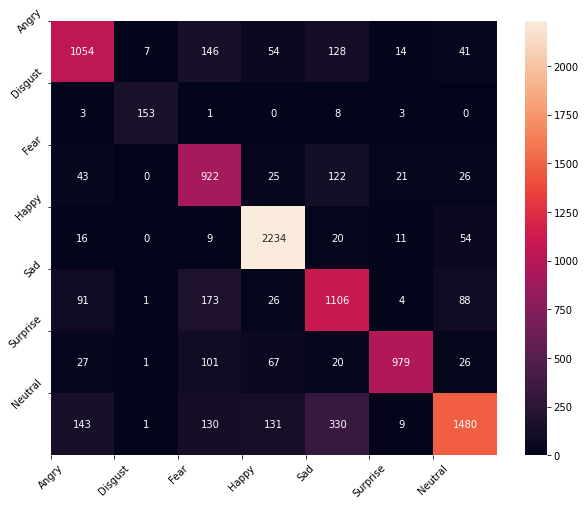

In [28]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_val))
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()), rotation = 45)
plt.yticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()), rotation = 45)
plt.show()

### Saving Model 

In [35]:
default = 'model_'

In [36]:
def ret_latest_file(x):
    ans = os.listdir(f'{loc}/Models/')
    # print(ans)

    finlist = []

    re_pat = re.compile("([a-zA-Z]+_)([0-9]+)")
    for i in ans:
        try:
            res = re_pat.match(i).groups()   #type: ignore 
            # print(res)          
            if res[0] == x:
                finlist.append(int(res[1]))            
        except:
            pass
    # print(finlist)
    if len(finlist) > 0:
        return max(finlist)
    else:
        return 0
    
# ret_latest_file(default)

In [38]:
name = f'{default}{int(ret_latest_file(default)) + 1}'

model_json = model.to_json()
try:
  os.mkdir(f'{loc}Models/{name}')
except:
  pass
  
with open(f'{loc}Models/{name}/{name}.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(f'{loc}Models/{name}/{name}.h5')
print("Saved model to disk")

Saved model to disk
